## Importing the required libraries

In [0]:
!git clone -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 345 (delta 23), reused 35 (delta 16), pack-reused 297
Receiving objects: 100% (345/345), 1.36 MiB | 8.99 MiB/s, done.
Resolving deltas: 100% (195/195), done.
/content/emotenn


In [0]:
import os
import glob
import time
import pickle
import librosa
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from emotenn import constants as ct, gen_utils as gu, train_utils as tu, load_utils as lu, plot_utils as pu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks

## Preprocess the audio data

In [0]:
for archive in [ct.RAVDESS_SPEECH, ct.RAVDESS_SONG]:
    lu.download_file_from_google_drive(archive, exist_ok=True)
    gu.unpack(archive.path)

In [0]:
sound_files_pattern = os.path.join(ct.UNPACKED_DIR, 'Audio_*_Actors_01-24', '**', '*.wav')
sound_files = sorted(glob.glob(sound_files_pattern, recursive=True))

In [0]:
labels = []
for sound_path in sound_files:
    name = os.path.basename(sound_path)
    emotion = name[6:8]
    if emotion in ['01', '02']:
        label = 'Neutral'
    elif emotion == '03':
        label = 'Happy'
    elif emotion == '04':
        label = 'Sad'
    elif emotion == '05':
        label = 'Angry'
    elif emotion == '06':
        label = 'Fear'
    elif emotion == '07':
        label = 'Disgust'
    elif emotion == '08':
        label = 'Surprise'
    labels.append(label)
dummies = pd.get_dummies(labels)[ct.CLASS_NAMES]
Y = dummies.to_numpy(dtype='float32')

In [0]:
def generate_features(mfcc_range):
    sound_data = []
    for sound_path in sound_files:
        y, sample_rate = librosa.load(sound_path, res_type='kaiser_fast', duration=2.5, sr=44100, offset=0.5)
        sound_data.append((y, sample_rate))

    mfcc_features = {}
    for mfcc_number in mfcc_range:
        mfcc_array = []
        for y, sample_rate in sound_data:
            mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=mfcc_number)
            # mfcc = normalize_mfcc(mfcc)
            mfcc_array.append(mfcc)

        # Fill missing elements with zeros
        result_shape = max([mfcc.shape for mfcc in mfcc_array])
        X = []
        for mfcc in mfcc_array:
            z = np.zeros((mfcc.shape[0], result_shape[1] - mfcc.shape[1]), dtype=mfcc.dtype)
            X.append(np.concatenate((mfcc,z), axis=1))
        mfcc_features[mfcc_number] = np.asarray(X)
    
    return mfcc_features

## Initialize static objects

In [0]:
strategy = tu.get_distribution_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [0]:
mfcc_features_file = ct.GDriveFile('1FntyzqdJBDciD0cgZazPOcpROSKkZyvM', os.path.join(ct.DATASETS_DIR, 'mfcc_features.bin'))
lu.download_file_from_google_drive(mfcc_features_file, exist_ok=True)
if os.path.exists(mfcc_features_file.path):
    with open(mfcc_features_file.path, 'rb') as f:
        mfcc_features, Y = pickle.load(f)
else:
    mfcc_features = generate_features(range(1, 41, 3))
    with open(mfcc_features_file.path, 'wb') as f:
        pickle.dump((mfcc_features, Y), f)

In [0]:
def get_results(build_model_fn, preprocess_fn=None, **kwargs):
    mfcc_results = {}
    preprocess_fn = preprocess_fn or (lambda x: x)

    if 'batch_size' not in kwargs:
        kwargs['batch_size'] = 128
    if 'epochs' not in kwargs:
        kwargs['epochs'] = 60

    for mfcc_number, features in mfcc_features.items():
        model = build_model_fn(mfcc_number)

        X = preprocess_fn(features)
        split = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
        X_train, X_valid, Y_train, Y_valid = split

        model_history = model.fit(X_train,
                                  Y_train,
                                  validation_data=(X_valid, Y_valid),
                                  **kwargs)
        accuracy = max(model_history.history['val_accuracy']) * 100
        mfcc_results[mfcc_number] = accuracy
        print(f'{mfcc_number:02}: {accuracy:.2f}')

    return mfcc_results

In [0]:
def print_results(mfcc_results):
    for mfcc, accuracy in mfcc_results.items():
        print(f'{mfcc:02}: {accuracy:.2f}')

In [0]:
def evaluate_model_time(build_model_fn, preprocess_fn=None, mfcc_number=13, **kwargs):
    mfcc_results = {}
    preprocess_fn = preprocess_fn or (lambda x: x)

    if 'batch_size' not in kwargs:
        kwargs['batch_size'] = 128
    if 'epochs' not in kwargs:
        kwargs['epochs'] = 60

    features = mfcc_features[mfcc_number]
    model = build_model_fn(mfcc_number)

    X = preprocess_fn(features)
    split = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_train, X_valid, Y_train, Y_valid = split

    model_history = model.fit(X_train,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              **kwargs)
    
    total_time = 0
    for data in X_valid:
        expanded = np.expand_dims(data, 0)
        start = time.time()
        model.predict(expanded)
        end = time.time()
        total_time += (end - start)
    avg_time = total_time / len(X_valid) * 1000
    print(f"Avg time per audio: {avg_time:.2f} ms")
    return avg_time

## 1D CNN with frequency averaging


In [0]:
def build_cnn_1d(mfcc_number, first_block=True, second_block=True, third_block=True, l2=None):
    with strategy.scope():
        model = Sequential()
        model.add(Input((216,1)))

        if first_block:
            model.add(Conv1D(128, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))

            model.add(Conv1D(128, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling1D(pool_size=(4)))

        if second_block:
            model.add(Conv1D(256, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))

            model.add(Conv1D(256, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling1D(pool_size=(4)))

        if third_block:
            model.add(Conv1D(512, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))

            model.add(Conv1D(512, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
        
        model.add(Flatten())
        model.add(Dense(400))
        model.add(Activation('relu'))
        model.add(Dropout(0.3))
        model.add(Dense(7))
        model.add(Activation('softmax'))
        
        optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [0]:
def preprocess_1d(X):
    X = np.mean(X, axis=1)
    return np.expand_dims(X, -1)

### All CNN blocks

In [0]:
mfcc_1d = get_results(build_cnn_1d, preprocess_1d)

01: 59.06
04: 57.43
07: 55.80
10: 53.56
13: 53.16
16: 53.97
19: 49.29
22: 49.08
25: 44.81
28: 47.25
31: 47.66
34: 46.44
37: 43.38
40: 44.20


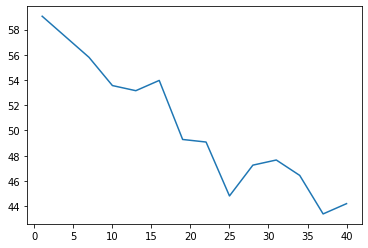

In [0]:
print_results(mfcc_1d)
plt.plot(list(mfcc_1d.keys()), list(mfcc_1d.values()))

### Two CNN blocks

In [0]:
mfcc_1d_2l = get_results(lambda: build_cnn_1d(third_block=False), preprocess_1d)

01: 59.47
04: 55.60
07: 56.42
10: 52.55
13: 52.55
16: 51.12
19: 48.27
22: 48.27
25: 44.60
28: 46.03
31: 45.82
34: 46.23
37: 45.62
40: 45.42


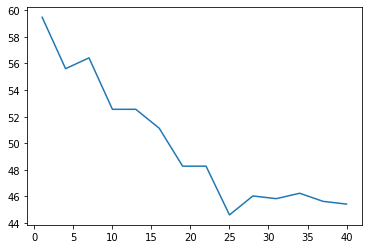

In [0]:
print_results(mfcc_1d_2l)
plt.plot(list(mfcc_1d_2l.keys()), list(mfcc_1d_2l.values()))

### One CNN block

In [0]:
mfcc_1d_1l = get_results(lambda: build_cnn_1d(second_block=False, third_block=False), preprocess_1d)

01: 54.18
04: 51.73
07: 51.12
10: 49.49
13: 49.49
16: 48.88
19: 46.64
22: 45.82
25: 42.57
28: 42.16
31: 45.01
34: 42.77
37: 41.75
40: 42.16


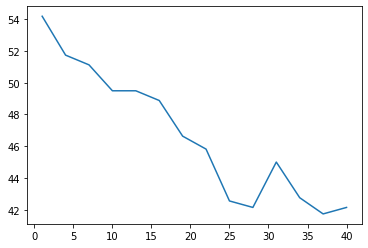

In [0]:
print_results(mfcc_1d_1l)
plt.plot(list(mfcc_1d_1l.keys()), list(mfcc_1d_1l.values()))

Text(0, 0.5, 'Accuracy')

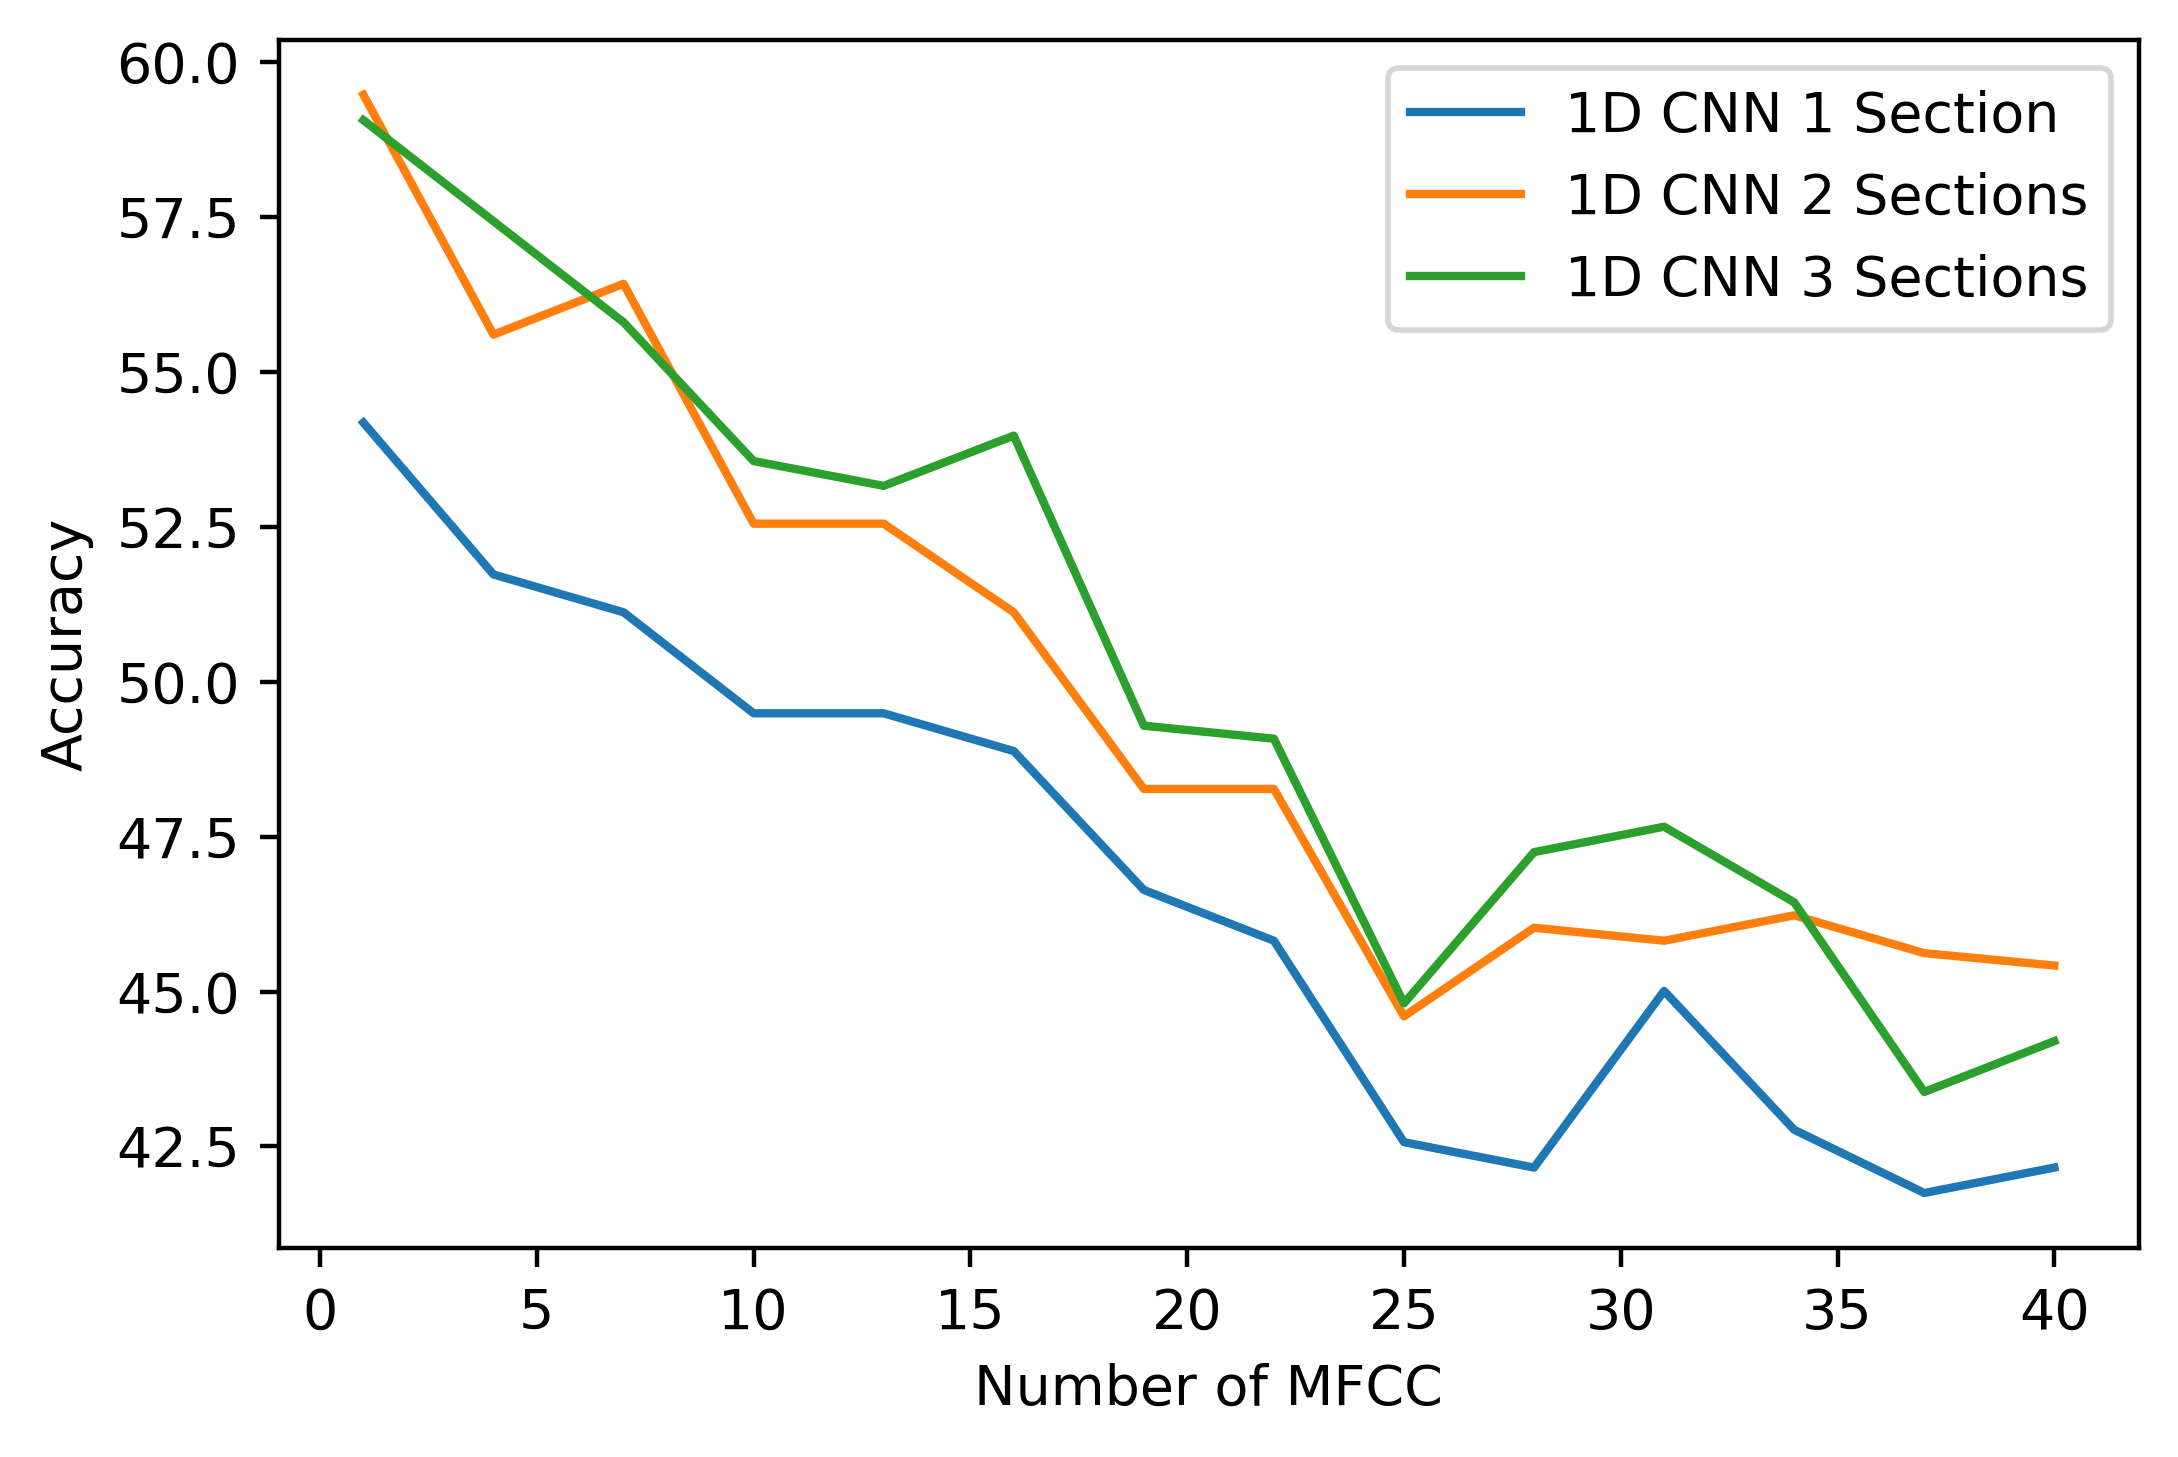

In [0]:
mfcc_1d_1sec = [54.18, 51.73, 51.12, 49.49, 49.49, 48.88, 46.64, 45.82, 42.57, 42.16, 45.01, 42.77, 41.75, 42.16]
mfcc_1d_2sec = [59.47, 55.60, 56.42, 52.55, 52.55, 51.12, 48.27, 48.27, 44.60, 46.03, 45.82, 46.23, 45.62, 45.42]
mfcc_1d_3sec = [59.06, 57.43, 55.80, 53.56, 53.16, 53.97, 49.29, 49.08, 44.81, 47.25, 47.66, 46.44, 43.38, 44.20]
x_ticks = list(mfcc_features.keys())
plt.plot(x_ticks, mfcc_1d_1sec, label="1D CNN 1 Section")
plt.plot(x_ticks, mfcc_1d_2sec, label="1D CNN 2 Sections")
plt.plot(x_ticks, mfcc_1d_3sec, label="1D CNN 3 Sections")
# show a legend on the plot
plt.xlabel('Number of MFCC')
plt.ylabel('Accuracy')
plt.legend()

## 1D CNN with time averaging 

In [0]:
def build_cnn_1d_time_av(mfcc_number, l2=None):
    with strategy.scope():
        model = Sequential()
        model.add(Input((mfcc_number,1)))
        model.add(Conv1D(128, 5, padding='same'))
        model.add(Activation('relu'))
        model.add(Dropout(0.1))

        if (mfcc_number > 8):
            model.add(MaxPooling1D(pool_size=(8)))

        model.add(Conv1D(128, 5, padding='same',))
        model.add(Activation('relu'))
        model.add(Dropout(0.1))
    
        model.add(Flatten())
        model.add(Dense(7))
        model.add(Activation('softmax'))

        #optimizer = tf.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
        optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [0]:
def preprocess_1d_time_av(X_orig):
    X = []
    for x in X_orig:
        mfcc = np.mean(x, axis=1)
        X.append(mfcc)
    X = np.asarray(X, dtype=np.float32)
    return np.expand_dims(X, -1)

In [0]:
mfcc_1d_time_av = get_results(build_cnn_1d_time_av, preprocess_1d_time_av, 
                              batch_size=128, epochs=1000)

In [0]:
print_results(mfcc_1d_time_av)

01: 31.36
04: 37.07
07: 45.01
10: 37.88
13: 37.07
16: 48.68
19: 46.84
22: 47.05
25: 58.04
28: 58.66
31: 58.86
34: 64.56
37: 64.97
40: 69.04


In [0]:
def build_cnn_1d_time_av_blocks(mfcc_number, first_block=True, second_block=True, third_block=True, l2=None):
    with strategy.scope():
        model = Sequential()
        model.add(Input((mfcc_number,1)))

        if first_block:
            model.add(Conv1D(128, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))

            model.add(Conv1D(128, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            if model.layers[-1].output_shape[1] >= 4:
                model.add(MaxPooling1D(pool_size=(4)))

        if second_block and model.layers[-1].output_shape[1] >= 4:
            model.add(Conv1D(256, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))

            model.add(Conv1D(256, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            if model.layers[-1].output_shape[1] >= 4:
                model.add(MaxPooling1D(pool_size=(4)))

        if third_block and model.layers[-1].output_shape[1] >= 4:
            model.add(Conv1D(512, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))

            model.add(Conv1D(512, 9, padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
        
        model.add(Flatten())
        model.add(Dense(400))
        model.add(Activation('relu'))
        model.add(Dropout(0.3))
        model.add(Dense(7))
        model.add(Activation('softmax'))
        
        optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [0]:
mfcc_1d_time_av_3_blocks = get_results(build_cnn_1d_time_av_blocks, preprocess_1d_time_av, 
                                       batch_size=128, epochs=200)

In [0]:
print_results(mfcc_1d_time_av_3_blocks)

01: 35.44
04: 42.36
07: 46.03
10: 56.42
13: 60.90
16: 75.97
19: 78.82
22: 77.80
25: 80.65
28: 81.67
31: 81.47
34: 81.47
37: 83.50
40: 83.10


In [0]:
def build_model_fn(mfcc_number):
    return build_cnn_1d_time_av_blocks(mfcc_number, third_block=False)

mfcc_1d_time_av_2_blocks = get_results(build_model_fn, 
                                       preprocess_1d_time_av, 
                                       batch_size=128, epochs=200)

In [0]:
print_results(mfcc_1d_time_av_2_blocks)

01: 35.64
04: 42.77
07: 47.25
10: 56.42
13: 60.29
16: 75.76
19: 77.80
22: 79.84
25: 82.08
28: 81.67
31: 80.24
34: 82.89
37: 83.10
40: 83.10


In [0]:
def build_model_fn(mfcc_number):
    return build_cnn_1d_time_av_blocks(mfcc_number, second_block=False, third_block=False)

mfcc_1d_time_av_1_block = get_results(build_model_fn, 
                                      preprocess_1d_time_av, 
                                      batch_size=128, epochs=200)

In [0]:
print_results(mfcc_1d_time_av_1_block)

01: 35.44
04: 41.75
07: 47.45
10: 55.60
13: 61.91
16: 67.62
19: 69.65
22: 74.13
25: 76.37
28: 76.78
31: 76.37
34: 76.78
37: 79.23
40: 79.23


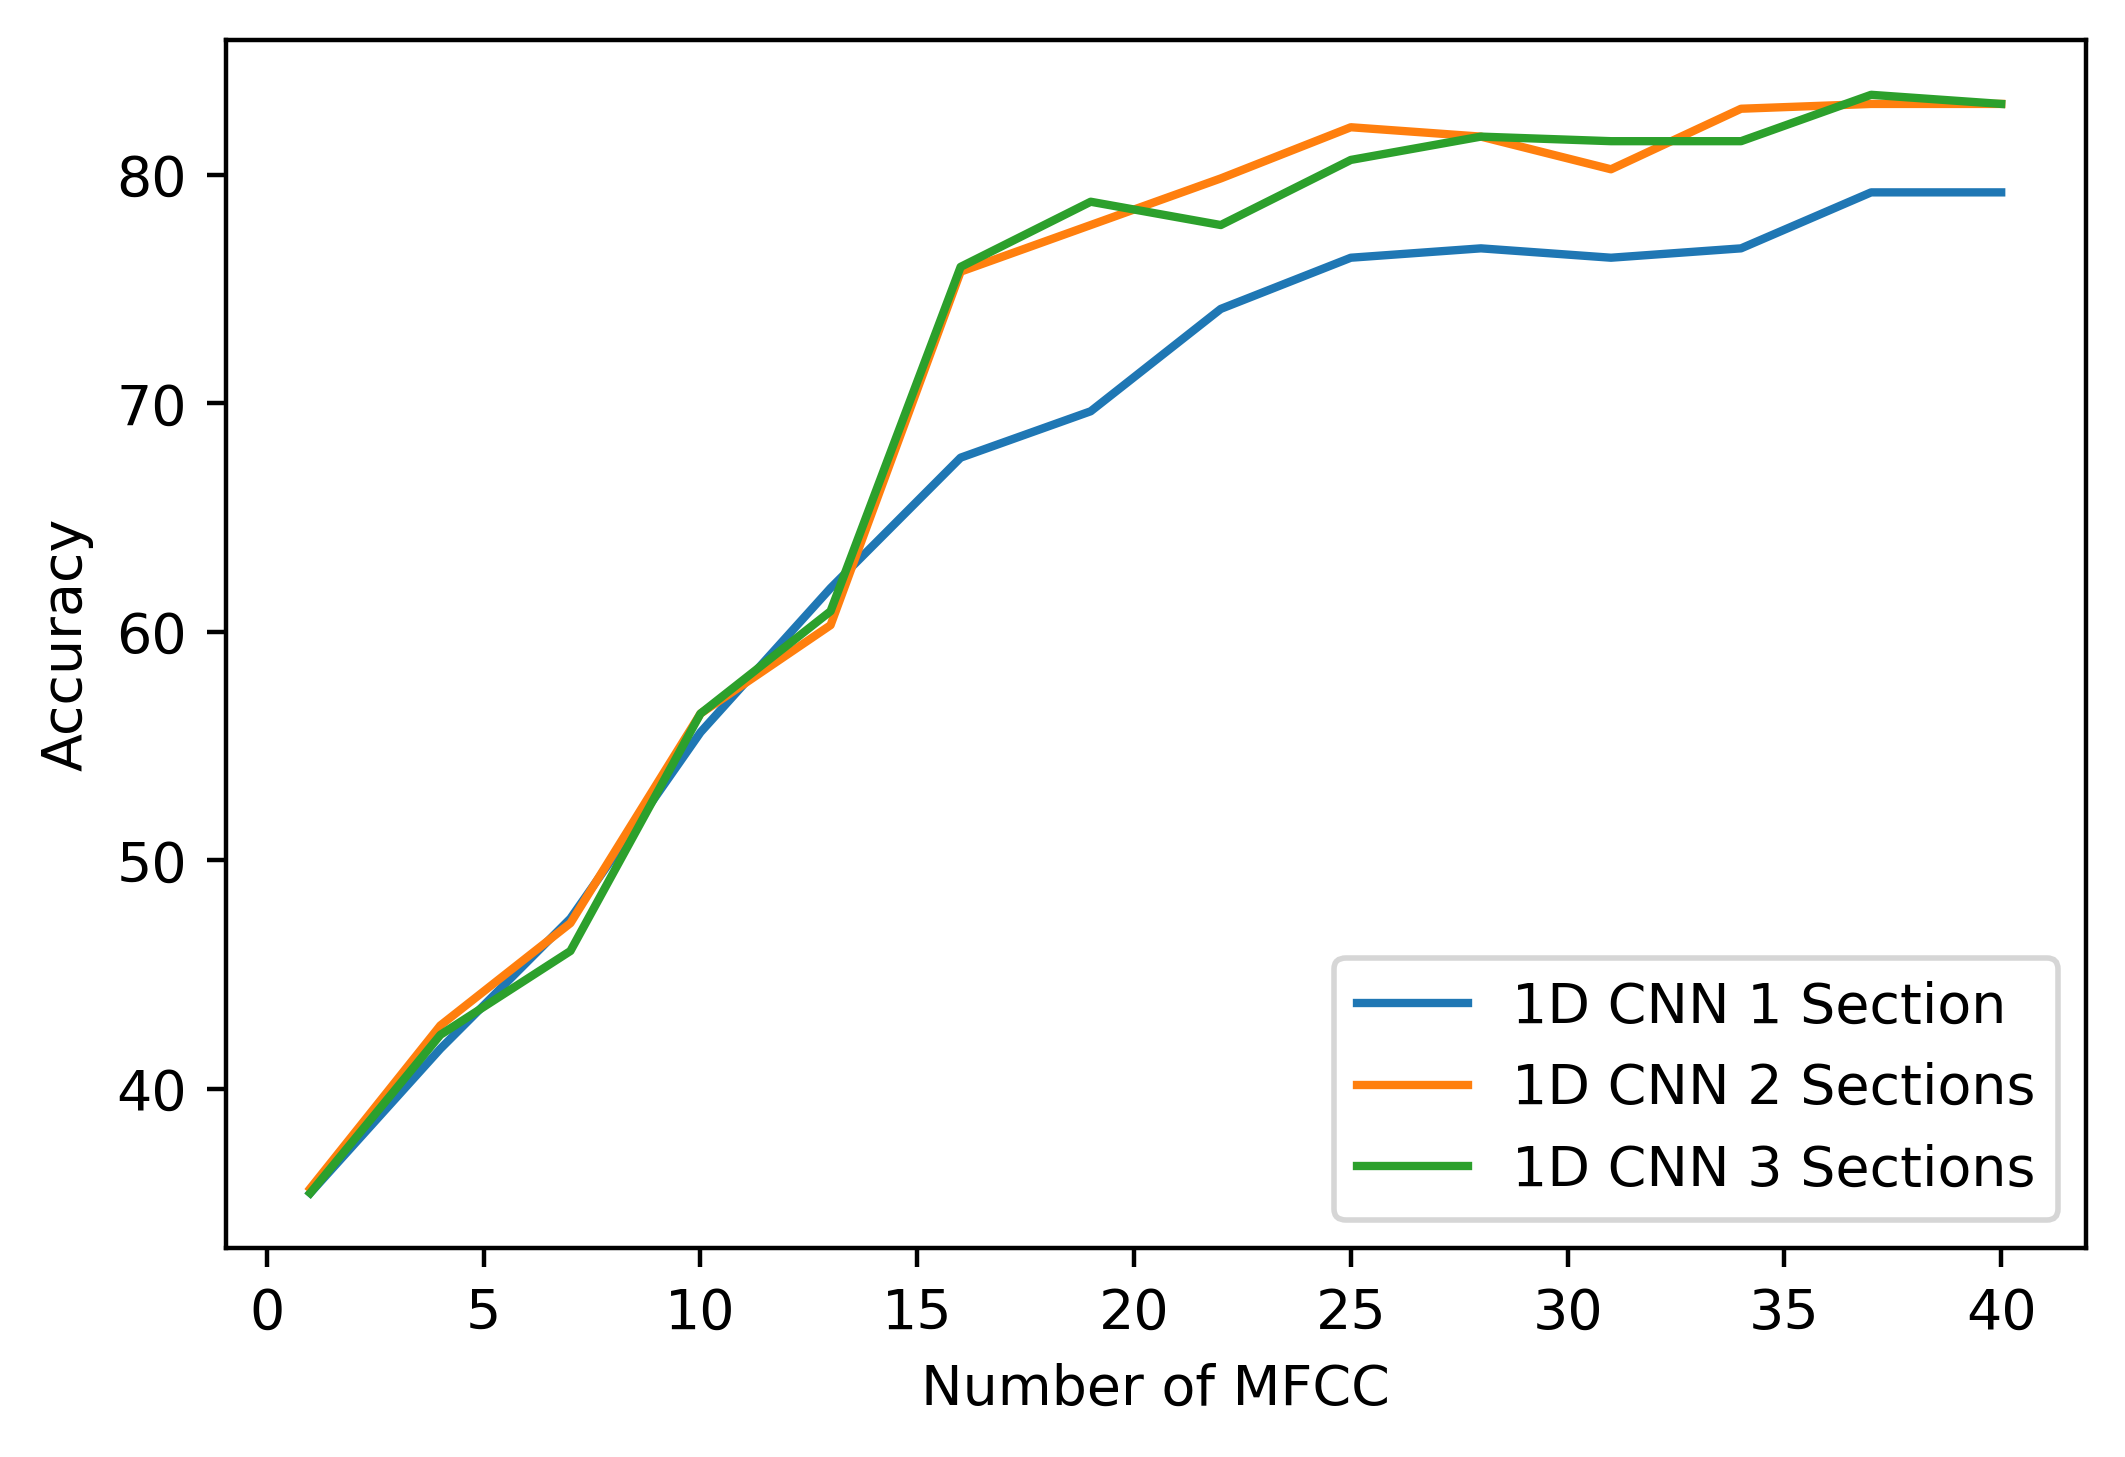

In [0]:
one_block = [35.44, 41.75, 47.45, 55.60, 61.91, 67.62, 69.65, 74.13, 76.37, 76.78, 76.37, 76.78, 79.23, 79.23]
two_blocks = [35.64, 42.77, 47.25, 56.42, 60.29, 75.76, 77.80, 79.84, 82.08, 81.67, 80.24, 82.89, 83.10, 83.10]
three_blocks = [35.44, 42.36, 46.03, 56.42, 60.90, 75.97, 78.82, 77.80, 80.65, 81.67, 81.47, 81.47, 83.50, 83.10]
ticks = list(mfcc_features.keys())

plt.plot(ticks, one_block, label="1D CNN 1 Section")
plt.plot(ticks, two_blocks, label="1D CNN 2 Sections")
plt.plot(ticks, three_blocks, label="1D CNN 3 Sections")

plt.xlabel('Number of MFCC')
plt.ylabel('Accuracy')
plt.legend()

## 2D CNN

In [0]:
def preprocess_2d(X):
    return np.expand_dims(X, -1)

In [0]:
def build_cnn_2d(mfcc_number, third_block=True, l2=None):
    with strategy.scope():
        model = Sequential()

        model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2,
                        input_shape=(mfcc_number, 216, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(1, 4)))

        model.add(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(1, 4)))

        if third_block:
            model.add(Conv2D(512, (5, 5), padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))

            model.add(Conv2D(512, (5, 5), padding='same', kernel_regularizer=l2))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(1, 4)))

        model.add(Flatten())
        model.add(Dense(2000))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(7))
        model.add(Activation('softmax'))

        print(model.summary())

        optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [0]:
mfcc_results_2d = get_results(build_cnn_2d, preprocess_2d, batch_size=64, epochs=70)

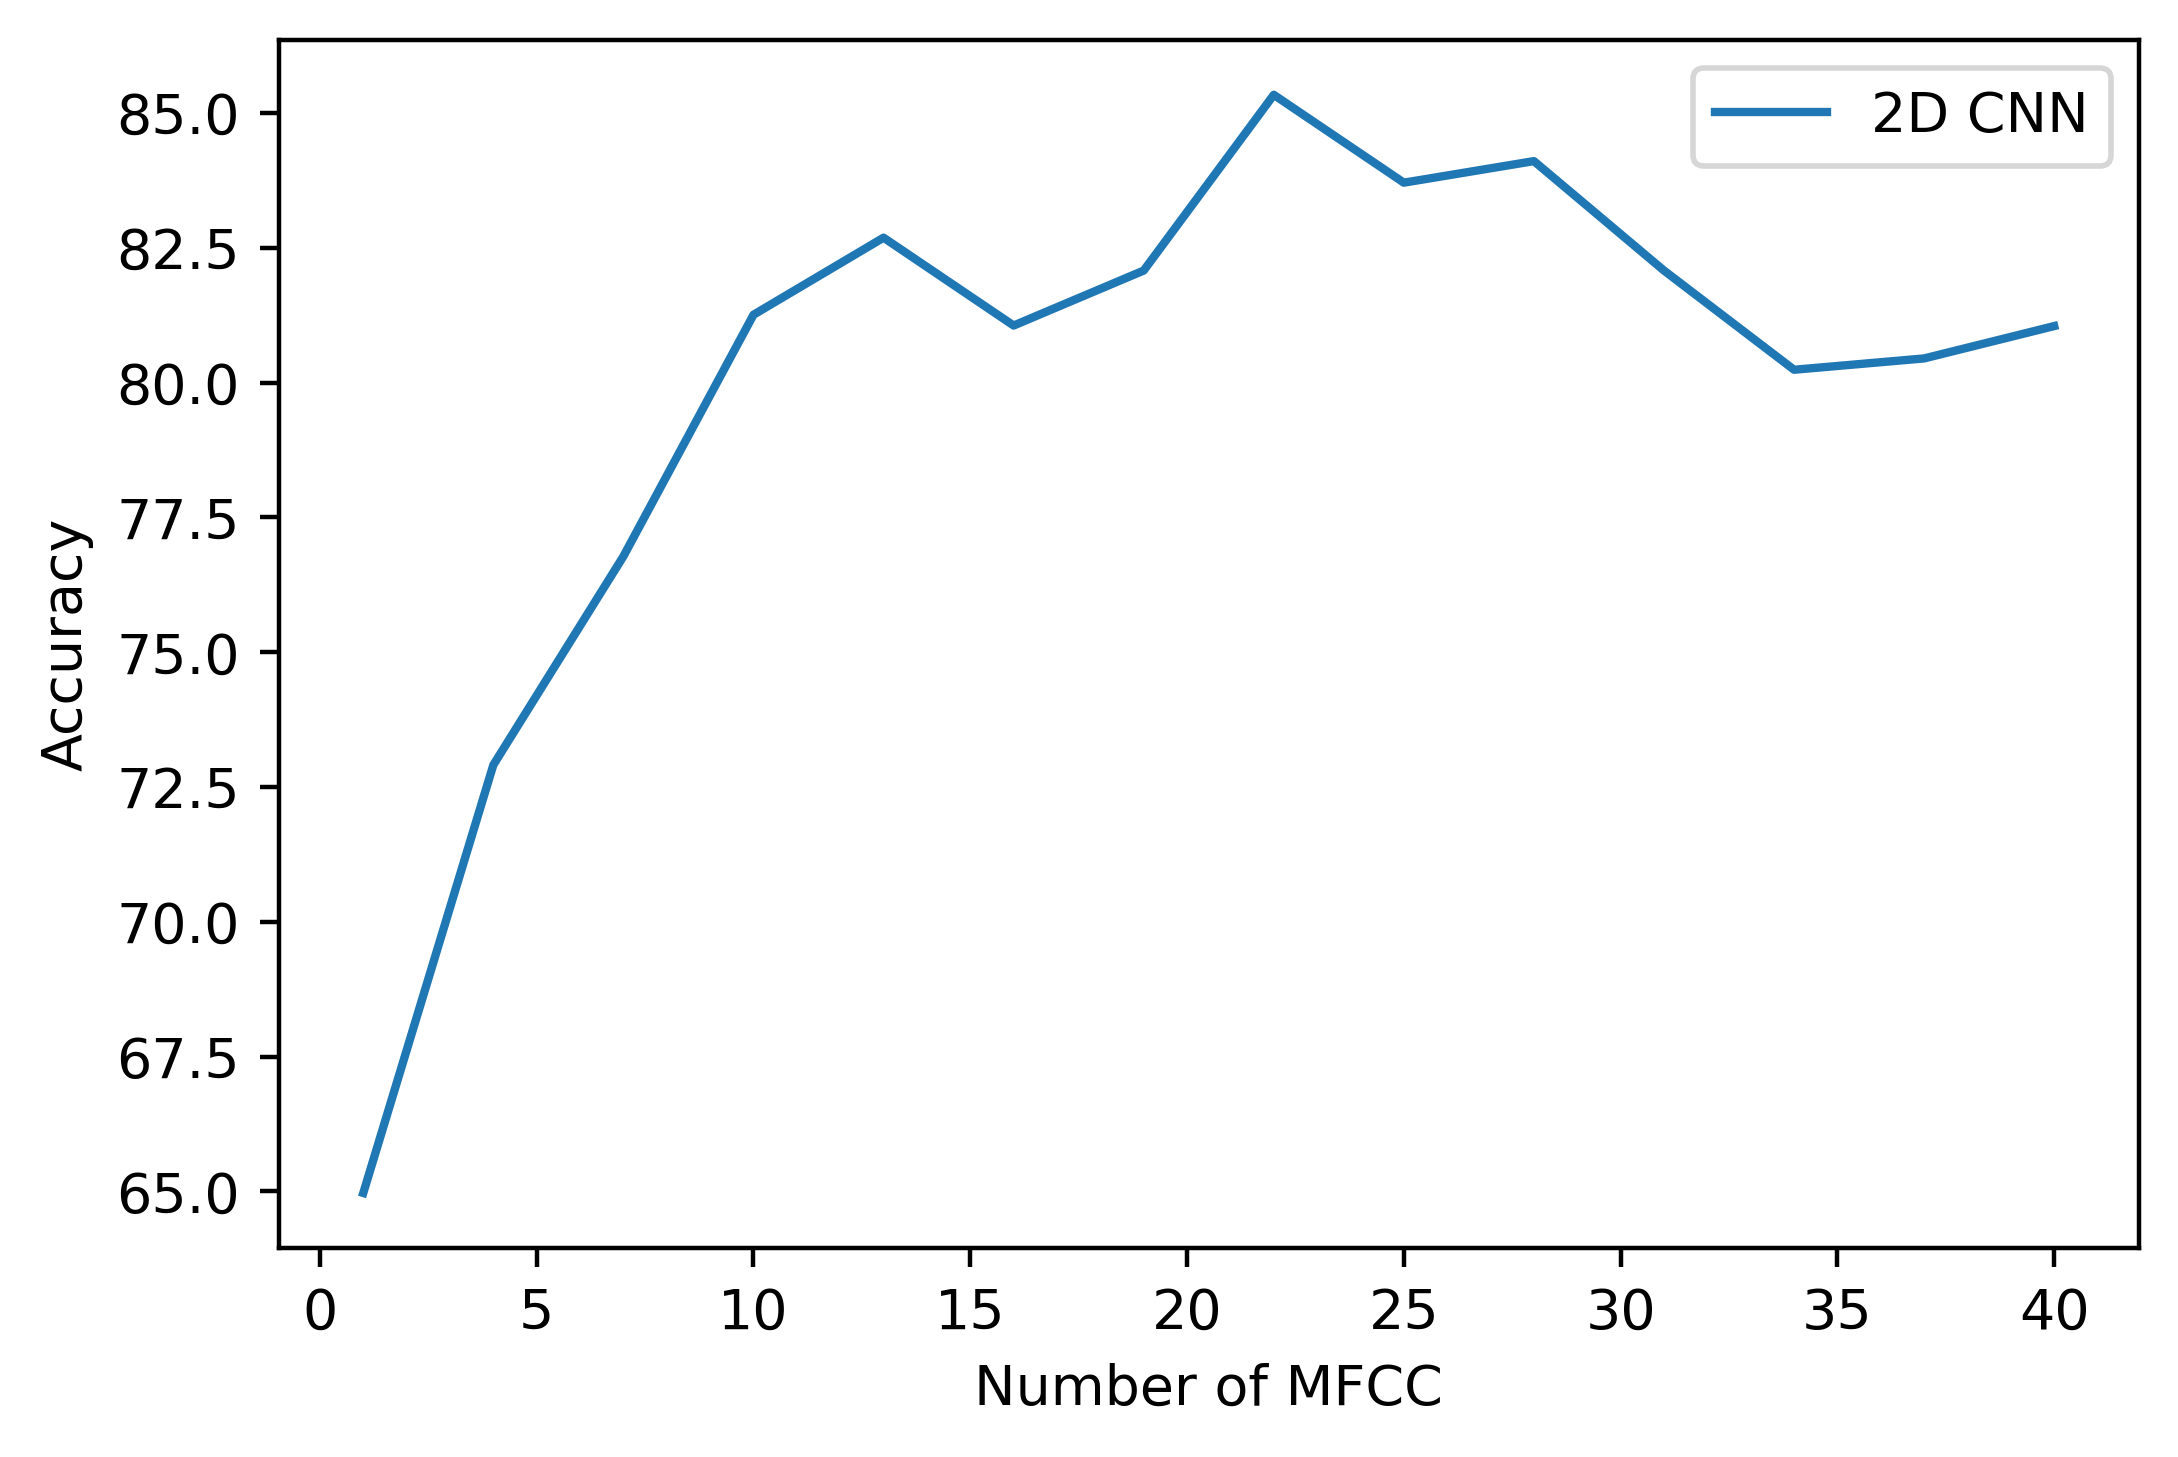

In [0]:
cnn_2d = [64.97, 72.91, 76.78, 81.26, 82.69, 81.06, 82.08, 85.34, 83.71, 84.11, 82.08, 80.24, 80.45, 81.05]
ticks = list(mfcc_features.keys())

plt.plot(ticks, cnn_2d, label="2D CNN")
plt.xlabel('Number of MFCC')
plt.ylabel('Accuracy')
plt.legend()

### Two blocks in 2D CNN

In [0]:
mfcc_results_2d_2_blocks = get_results(lambda mfcc_num: build_cnn_2d(mfcc_num, third_block=False),
                              preprocess_2d,
                              batch_size=64,
                              epochs=70)

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_156 (Conv2D)          (None, 1, 216, 128)       3328      
_________________________________________________________________
batch_normalization_156 (Bat (None, 1, 216, 128)       512       
_________________________________________________________________
activation_184 (Activation)  (None, 1, 216, 128)       0         
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 1, 216, 128)       409728    
_________________________________________________________________
batch_normalization_157 (Bat (None, 1, 216, 128)       512       
_________________________________________________________________
activation_185 (Activation)  (None, 1, 216, 128)       0         
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 1, 54, 128)      

In [0]:
print_results(mfcc_results_2d_2_blocks)

01: 56.62
04: 70.47
07: 75.76
10: 74.75
13: 73.32
16: 75.36
19: 77.19
22: 76.99
25: 78.41
28: 76.17
31: 76.58
34: 76.17
37: 76.58
40: 75.56


## LSTM and Bidirectional LSTM

In [0]:
def normalize_mfcc(mfcc):
    mean = np.mean(mfcc, axis=1)
    std = np.std(mfcc, axis=1)
    mfcc = mfcc.transpose()
    mfcc -= mean
    mfcc /= std
    return mfcc.transpose()

def preprocess_lstm(X_orig):
    norm_mfcc = []
    for x in X_orig:
        mfcc = normalize_mfcc(x)
        norm_mfcc.append(mfcc)
    # Transform dimensions to the form of (count, timesteps, features)
    norm_mfcc = np.asarray(norm_mfcc, dtype=np.float32)
    return np.swapaxes(norm_mfcc, 1, 2)

### LSTM

In [0]:
def build_lstm(mfcc_number, hidden_nodes=200, dropout=0.2):
    with strategy.scope():
        model = Sequential()
        model.add(Input((216, mfcc_number)))
        model.add(LSTM(hidden_nodes, dropout=dropout))
        model.add(Dense(7, activation='softmax'))

        optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

In [0]:
mfcc_results_lstm = get_results(build_lstm, preprocess_lstm, batch_size=128, epochs=200)

In [0]:
print_results(mfcc_results_lstm)

01: 46.64
04: 58.45
07: 67.41
10: 71.49
13: 70.47
16: 74.54
19: 71.08
22: 70.67
25: 71.28
28: 72.10
31: 71.69
34: 70.67
37: 70.06
40: 69.45


### Bidirectional LSTM

In [0]:
def build_bd_lstm(mfcc_number, hidden_nodes=200, dropout=0.2):
    with strategy.scope():
        model = Sequential()
        model.add(Input((216, mfcc_number)))
        model.add(Bidirectional(LSTM(hidden_nodes, dropout=dropout)))
        model.add(Dense(7, activation='softmax'))
        
        optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

In [0]:
mfcc_results_bd_lstm = get_results(build_bd_lstm, preprocess_lstm, batch_size=128, epochs=200)

In [0]:
print_results(mfcc_results_bd_lstm)

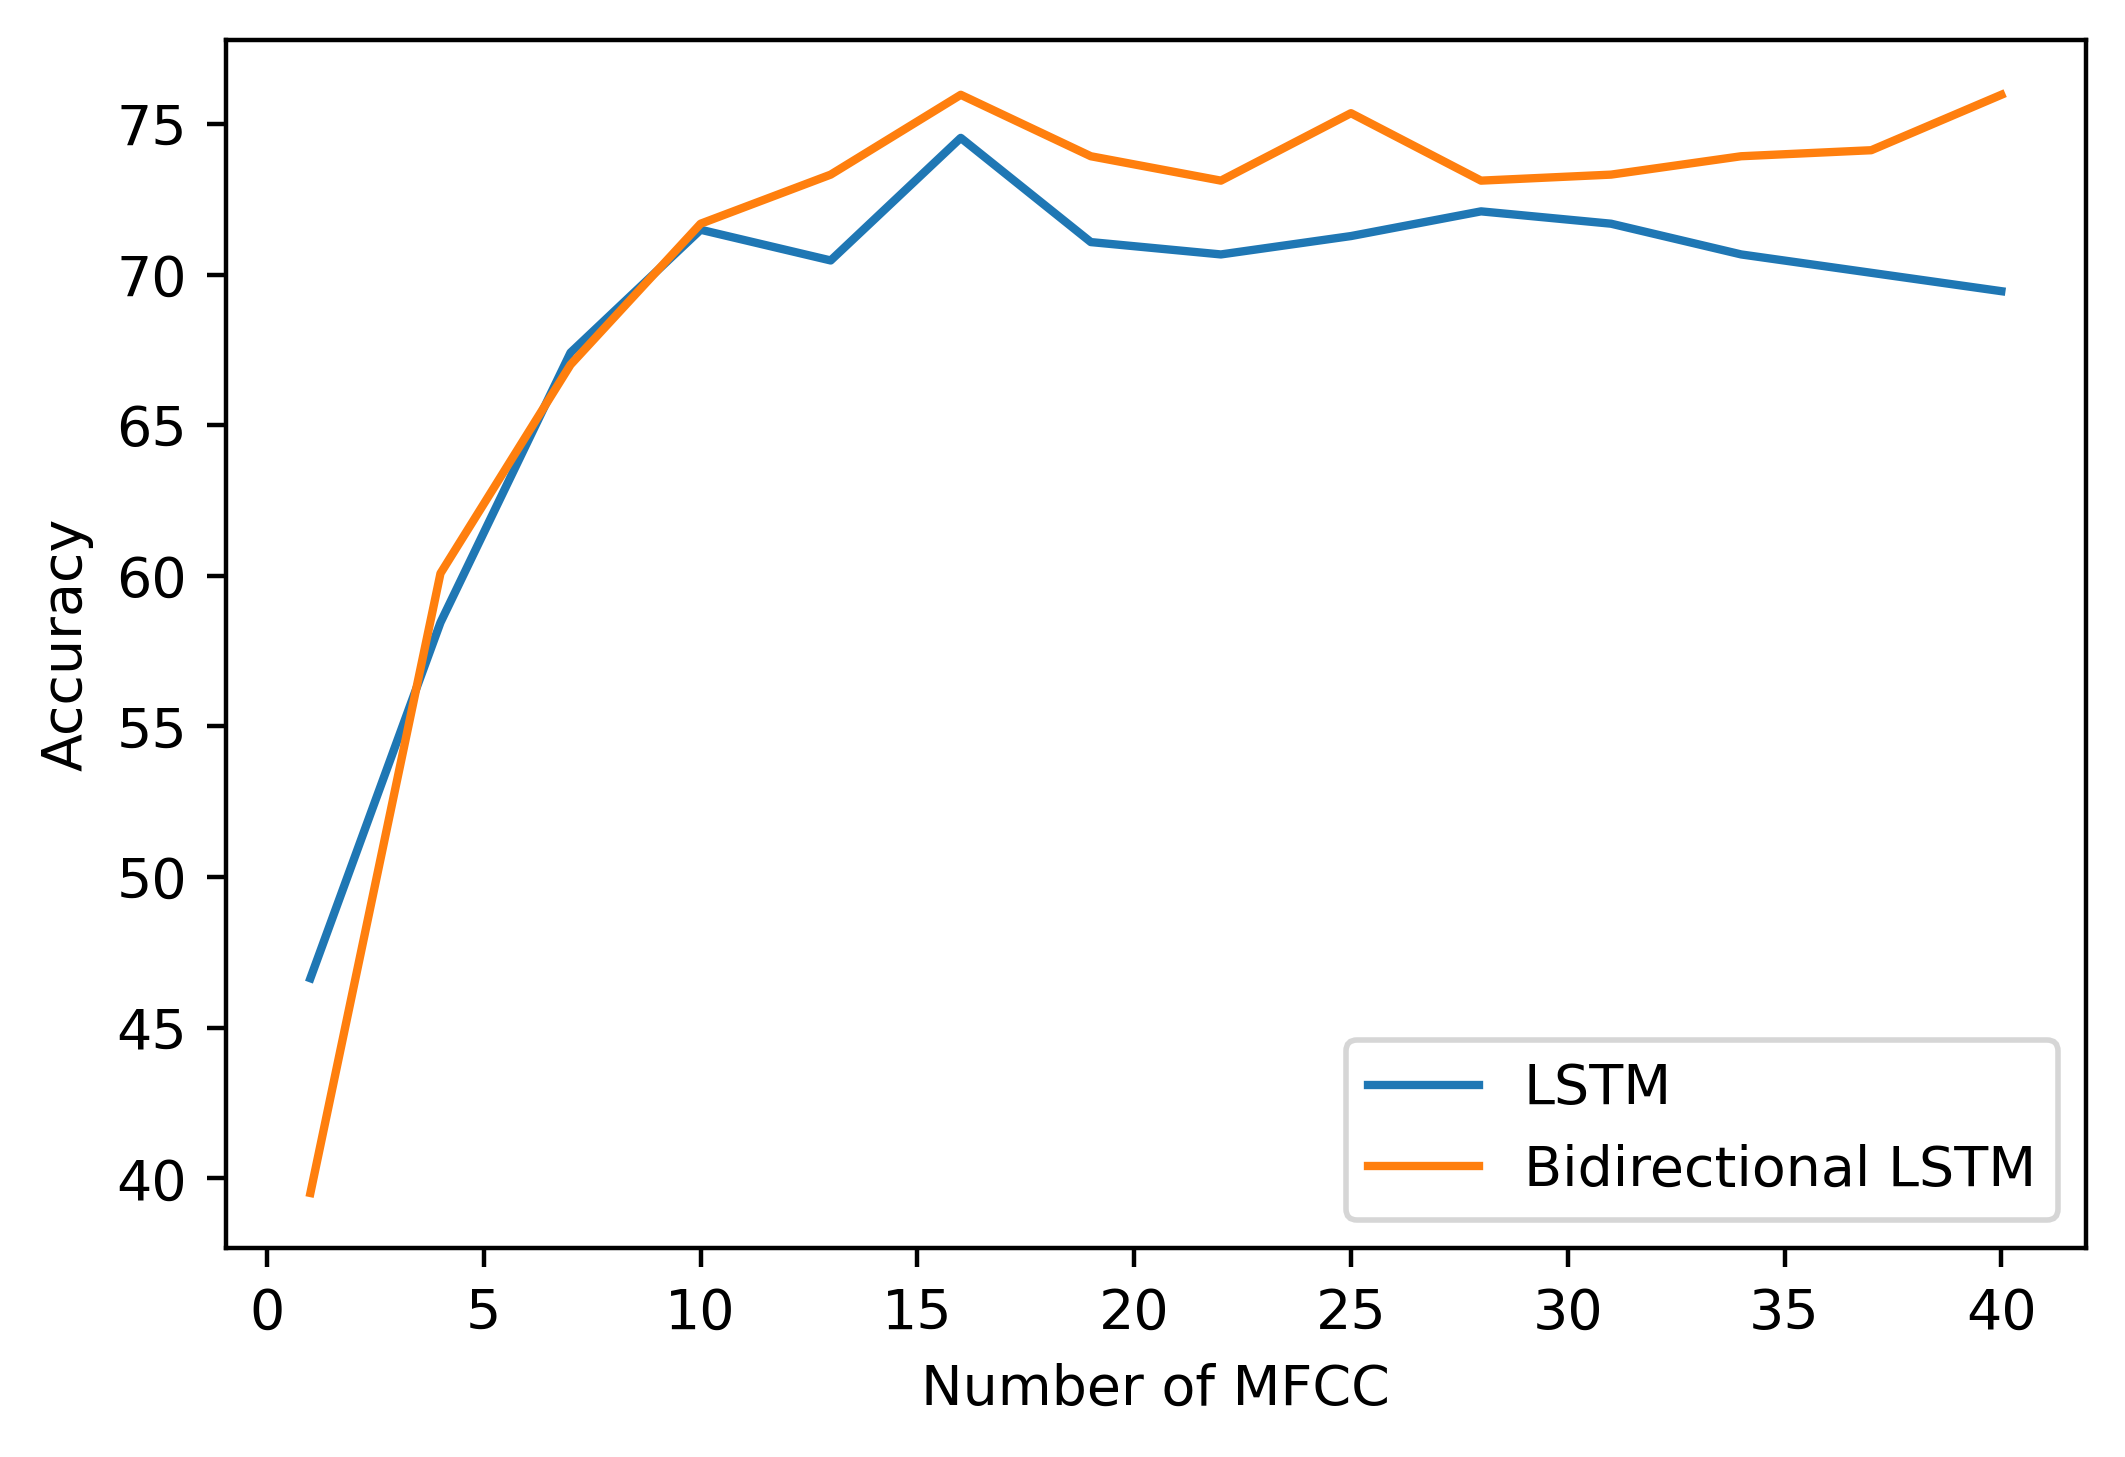

In [0]:
lstm = [46.64, 58.45, 67.41, 71.49, 70.47, 74.54, 71.08, 70.67, 71.28, 72.10, 71.69, 70.67, 70.06, 69.45]
bd_lstm = [39.51, 60.08, 67.01, 71.69, 73.32, 75.97, 73.93, 73.12, 75.36, 73.12, 73.32, 73.93, 74.13, 75.97]
ticks = mfcc_features.keys()

plt.plot(list(ticks), lstm, label='LSTM')
plt.plot(list(ticks), bd_lstm, label='Bidirectional LSTM')
plt.xlabel('Number of MFCC')
plt.ylabel('Accuracy')
plt.legend()